In [ ]:
# imported all the required libraries
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch 
import torch.nn as nn
import torch.nn.functional as F
import random
import re
import nltk
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
from string import punctuation
from torch.utils.data import Dataset, DataLoader
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import pickle

#### Data Loading

In [2]:
# This file contains the DTDC courier customer complaints 
data = pd.read_excel('DTDC_Complaints_Dataset.xlsx')
data.head(10)

,Complaint Text,Category
0,Support team ignored my issue.,Service Quality Issue
1,Wrong address printed.,Booking Issue
2,Delivery attempt was not made.,Failed Delivery
3,App crashes during booking.,Booking Issue
4,Repeated failed delivery attempts without cont...,Failed Delivery
5,Support promised a call back that never came.,Customer Service
6,Took more than 10 days to deliver.,Delivery Delay
7,Support promised a call back that never came.,Customer Service
8,Electronics arrived damaged.,Damaged Parcel
9,The shipment was held at the local office for ...,Delivery Delay


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3500 entries, 0 to 3499
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Complaint Text  3500 non-null   object
 1   Category        3500 non-null   object
dtypes: object(2)
memory usage: 54.8+ KB


In [ ]:
data['Category'].value_counts() # here all the classes are balanced.

Category
Service Quality Issue    381
Tracking Issue           368
Booking Issue            351
Customer Service         351
Delivery Delay           351
Failed Delivery          350
Overcharging             349
Damaged Parcel           333
Wrong Delivery           333
Misplaced Parcel         333
Name: count, dtype: int64

In [5]:
data['Category'].value_counts().to_numpy().mean()

350.0

#### Text Processing

The text processing steps I took are 
1. Removing punctuations from the text.
2. Tokenizing the sentences into words.
3. Removing stopwords.
4. Performing Lemmatization

In [6]:
def data_preprocessing(text):
    text = "".join([char for char in text if char not in punctuation])
    text = word_tokenize(text.lower())
    text = [word for word in text if word not in stopwords.words('english')]
    text = [WordNetLemmatizer().lemmatize(word) for word in text]
    return text

In [ ]:
# Took the column in which all the data was cleaned and tokenized
data['Cleaned_Complaint_text'] = data['Complaint Text'].apply(lambda x : data_preprocessing(x))

In [ ]:
# Extracted all unique words from the complaint sentences
sentences = data['Cleaned_Complaint_text']
vocabulary = []
for sentence in sentences:
    vocabulary.extend(sentence)
vocabulary = list(set(vocabulary))

In [ ]:
vocabulary # words present in the entire dataset

['never',
 'applied',
 'category',
 'consignment',
 'followup',
 'nearby',
 'glass',
 'still',
 'serviceable',
 'hidden',
 'express',
 'agent',
 'available',
 'unable',
 'electronic',
 'different',
 'inside',
 'several',
 'trace',
 'repeated',
 'shipment',
 'track',
 'keep',
 'card',
 'know',
 'handling',
 'trying',
 '30',
 'city',
 'boy',
 'reached',
 'info',
 'book',
 'minute',
 'cancelled',
 'customer',
 'delayed',
 'paid',
 'unjustified',
 'address',
 'website',
 'citing',
 'despite',
 'scheduled',
 'delivered',
 'premium',
 'content',
 'item',
 '5',
 'double',
 'wearing',
 'day',
 'invalid',
 'simple',
 'shop',
 'packaging',
 'got',
 'poor',
 'assistance',
 'gave',
 'disappeared',
 'get',
 'pin',
 'completely',
 'online',
 'attempt',
 'hub',
 'app',
 'unavailable',
 'technical',
 'support',
 'came',
 'help',
 'delay',
 'amount',
 'received',
 'booking',
 '10',
 'lost',
 'else',
 'portal',
 'proper',
 'fee',
 'refused',
 'crash',
 'idea',
 'took',
 'provide',
 'carelessly',
 'false

In [10]:
data

,Complaint Text,Category,Cleaned_Complaint_text
0,Support team ignored my issue.,Service Quality Issue,"[support, team, ignored, issue]"
1,Wrong address printed.,Booking Issue,"[wrong, address, printed]"
2,Delivery attempt was not made.,Failed Delivery,"[delivery, attempt, made]"
3,App crashes during booking.,Booking Issue,"[app, crash, booking]"
4,Repeated failed delivery attempts without cont...,Failed Delivery,"[repeated, failed, delivery, attempt, without,..."
...,...,...,...
3495,DTDC team never picked up the parcel as schedu...,Service Quality Issue,"[dtdc, team, never, picked, parcel, scheduled]"
3496,"Tracking shows delivered, but I haven’t receiv...",Tracking Issue,"[tracking, show, delivered, ’, received]"
3497,No one knows where my item is.,Misplaced Parcel,"[one, know, item]"
3498,Incorrect invoice amount.,Overcharging,"[incorrect, invoice, amount]"


In [ ]:
# Added the small noise so that the model generalizes well
def add_text_noise(tokenized_text, noise_rate=0.1):
    noisy_text = []
    for word in tokenized_text:
        if random.random() < noise_rate:
            if len(word) > 1:
                idx = random.randint(0, len(word) - 1)
                ch = random.choice('abcdefghijklmnopqrstuvwxyz')
                noisy_word = word[:idx] + ch + word[idx+1:]
                noisy_text.append(noisy_word)
            else:
                noisy_text.append(word)
        else:
            noisy_text.append(word)
    return noisy_text


In [12]:
data['Noisy_Complaint_Text'] = data['Cleaned_Complaint_text'].apply(lambda x: add_text_noise(x, noise_rate=0.05))

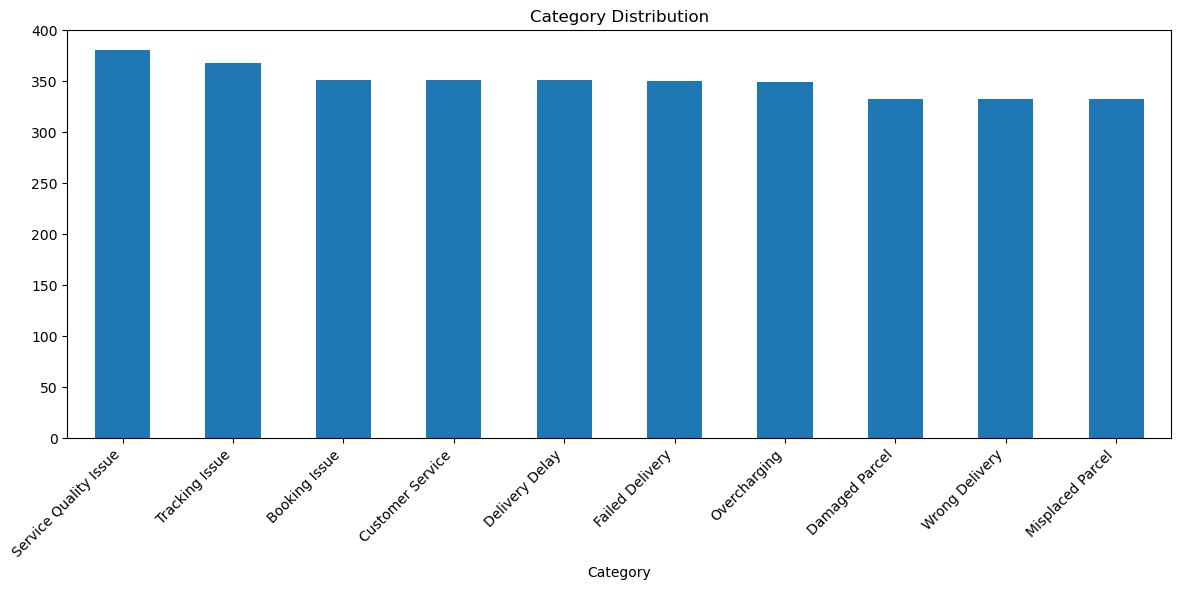

In [ ]:
# Visualization of 10 categories
plt.figure(figsize=(12, 6))
data['Category'].value_counts().plot(kind='bar')
plt.title('Category Distribution')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### Feature Engineering

In [13]:
# length of characters in a sentence is returned here 
def len_of_text(text):
    return len("".join(text.split()))

In [14]:
data['text_len'] = data['Complaint Text'].apply(lambda x: len("".join(x.split())))

In [ ]:
# Here the punctuation's percentage is returned
def Punc_per(text):
    count = sum([1 for char in text if char in punctuation])
    return round(count/(len(text)-text.count(" "))*100,3)

In [16]:
data['punctuation_percent'] = data['Complaint Text'].apply(lambda x : Punc_per(x))

In [17]:
data[['Cleaned_Complaint_text', 'text_len', 'Noisy_Complaint_Text', 'punctuation_percent']]

,Cleaned_Complaint_text,text_len,Noisy_Complaint_Text,punctuation_percent
0,"[support, team, ignored, issue]",26,"[support, team, ignored, issus]",3.846
1,"[wrong, address, printed]",20,"[wrong, address, printed]",5.000
2,"[delivery, attempt, made]",26,"[delivery, attempt, made]",3.846
3,"[app, crash, booking]",24,"[app, craeh, booking]",4.167
4,"[repeated, failed, delivery, attempt, without,...",50,"[repeated, failed, delivere, attempt, without,...",2.000
...,...,...,...,...
3495,"[dtdc, team, never, picked, parcel, scheduled]",42,"[dtdc, team, never, picked, parcel, scheduled]",2.381
3496,"[tracking, show, delivered, ’, received]",45,"[tracking, show, delivered, ’, received]",4.444
3497,"[one, know, item]",24,"[one, know, item]",4.167
3498,"[incorrect, invoice, amount]",23,"[incorrect, invoice, amount]",4.348


In [18]:
data['Cleaned_Complaint_text'][0]

['support', 'team', 'ignored', 'issue']

In [19]:
data['Complaint Text'][0]

'Support team ignored my issue.'

Word2Vec

In [ ]:
# Used the word2vec to get the embeddings of the words in sentences
# used seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
sentences = data['Noisy_Complaint_Text']
w2v_model = Word2Vec(sentences,
                     vector_size=100, 
                     window=5, 
                     min_count=1, 
                     sg=1, 
                     seed=SEED, 
                     workers=1, 
                     epochs=10, 
                     sorted_vocab=True)

In [ ]:
# Embedding of consignment after word2vec
print(w2v_model.wv['consignment'])

[-1.30235955e-01 -1.01873778e-01 -2.89633550e-04 -1.84764743e-01
 -2.31033862e-01 -1.80361774e-02  1.94778085e-01  7.43437856e-02
 -1.36640325e-01 -6.22804686e-02 -2.93626904e-01 -5.07670715e-02
  5.11768758e-02  3.19621772e-01 -3.46098274e-01 -1.34268314e-01
  3.99483293e-01 -1.33437961e-01 -2.10945264e-01 -9.10326466e-02
 -2.61053801e-01  1.49855718e-01  1.27479866e-01  1.21344015e-01
 -2.78699189e-01  3.31909657e-01 -3.34401160e-01  2.92810231e-01
 -2.83276010e-02 -1.91725045e-01  1.42388120e-01 -4.18267958e-03
  2.94152796e-01  2.36285836e-01  8.84961635e-02  3.59168276e-03
  4.28316370e-03 -4.11715299e-01 -1.58709884e-02  1.29961431e-01
  1.57651454e-01 -9.13265646e-02  7.28690267e-01 -8.59528035e-02
  8.04879218e-02  2.43531037e-02  2.35209554e-01 -1.41583353e-01
  1.77233830e-01 -1.93478763e-01  1.71900481e-01 -3.85244936e-01
 -4.74914983e-02  1.11411333e-01  2.83199288e-02 -1.98996216e-01
  4.77505960e-02  1.03526928e-01  4.02372517e-02  2.73284733e-01
 -3.77056062e-01 -1.53112

Padding

In [ ]:
# padded sentence embeddings to fixed size length(max_len)
embedding_dim = 100
max_len = 20

def get_embedding_matrix(sentences, model, max_len):
    data = []
    for sent in sentences:
        vecs = []
        for word in sent:
            if word in model.wv:
                vecs.append(torch.tensor(model.wv[word]))
        if len(vecs) < max_len:
            pad_len = max_len - len(vecs)
            vecs.extend([torch.zeros(embedding_dim)] * pad_len)
        else:
            vecs = vecs[:max_len]
        data.append(torch.stack(vecs))
    return torch.stack(data)

#### Feed Farword Network

In [ ]:
# Stored padded embeddings in X
X = get_embedding_matrix(sentences, w2v_model, max_len)
print(X.shape)

torch.Size([3500, 20, 100])


In [ ]:
# Flattened [batch, max_len, embed_dim] to [batch, max_len*embed_dim] for feed-forward input
X = X.view(X.size(0), -1)
X.shape

torch.Size([3500, 2000])

In [ ]:
# encoded the category column classes
encoder = LabelEncoder()
encoder = LabelEncoder()
choices = data['Category'].unique()
data['Noisy_Category'] = data['Category'].apply(
    lambda x: random.choice(choices) if random.random() < 0.1 else x
)
y = encoder.fit_transform(data['Noisy_Category'])

In [ ]:
# Scaled the engineered features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data[['text_len', 'punctuation_percent']])
X_scalar = torch.tensor(scaled_features, dtype=torch.float32)

In [137]:
X_ffnn = torch.cat([X, X_scalar], dim=1)
y_ffnn = y

In [138]:
X_ffnn.shape

torch.Size([3500, 2002])

In [139]:
X_ffnn_train, X_ffnn_val, y_ffnn_train, y_ffnn_val = train_test_split(
    X_ffnn, y_ffnn, test_size=0.2, random_state=42
)

In [ ]:
# Defined a custom PyTorch Dataset
class ComplaintDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds_ffnn = ComplaintDataset(X_ffnn_train, torch.tensor(y_ffnn_train, dtype=torch.long))
val_ds_ffnn = ComplaintDataset(X_ffnn_val, torch.tensor(y_ffnn_val, dtype=torch.long))

In [141]:
train_loader_ffnn = DataLoader(train_ds_ffnn, batch_size=32, shuffle=True)
val_loader_ffnn = DataLoader(val_ds_ffnn, batch_size=32)

In [ ]:
# A simple feed forward network
class FeedForwardNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(FeedForwardNet, self).__init__()
        self.output_layer = nn.Linear(input_dim, output_dim)
    def forward(self, x):
        return self.output_layer(x)

In [ ]:
# initialized the network
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_ffnn = FeedForwardNet(input_dim=X_ffnn.shape[1], output_dim=len(set(y_ffnn))).to(device)

In [ ]:
# loss function and optimizer for training the FFNN
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_ffnn.parameters(), lr=1e-3, weight_decay=1e-4)

In [ ]:
# trained the feed-forward network for 10 epochs
train_losses = []
val_losses = []

for epoch in range(10):
    model_ffnn.train()
    running_loss = 0.0
    train_preds_all = []
    train_labels_all = []
    
    for batch_X, batch_y in train_loader_ffnn:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        preds = model_ffnn(batch_X)
        loss = criterion(preds, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        train_preds_all.extend(torch.argmax(preds, dim=1).cpu().numpy())
        train_labels_all.extend(batch_y.cpu().numpy())

    avg_train_loss = running_loss / len(train_loader_ffnn)
    model_ffnn.eval()
    val_loss = 0.0
    val_preds_all = []
    val_labels_all = []
    
    with torch.no_grad():
        for batch_X, batch_y in val_loader_ffnn:
            preds = model_ffnn(batch_X)
            loss = criterion(preds, batch_y)
            val_loss += loss.item()
            val_preds_all.extend(torch.argmax(preds, dim=1).cpu().numpy())
            val_labels_all.extend(batch_y.cpu().numpy())
    
    avg_val_loss = val_loss / len(val_loader_ffnn)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    
    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")


Epoch 1 | Train Loss: 1.7883 | Val Loss: 1.3635
Epoch 2 | Train Loss: 1.2205 | Val Loss: 1.0437
Epoch 3 | Train Loss: 0.9949 | Val Loss: 0.8987
Epoch 4 | Train Loss: 0.8779 | Val Loss: 0.8181
Epoch 5 | Train Loss: 0.8036 | Val Loss: 0.7656
Epoch 6 | Train Loss: 0.7504 | Val Loss: 0.7326
Epoch 7 | Train Loss: 0.7126 | Val Loss: 0.7067
Epoch 8 | Train Loss: 0.6847 | Val Loss: 0.6904
Epoch 9 | Train Loss: 0.6611 | Val Loss: 0.6768
Epoch 10 | Train Loss: 0.6427 | Val Loss: 0.6686


#### Evaluation

In [ ]:
# Switched model to eval mode and got predictions on the validation set.
model_ffnn.eval()
with torch.no_grad():
    preds = model_ffnn(X_ffnn_val)
    predicted_labels = torch.argmax(preds, dim=1)


Report

In [ ]:
y_true = y_ffnn_val
y_pred = predicted_labels.numpy()

print("Accuracy:", round(accuracy_score(y_true, y_pred), 2))

Accuracy: 0.9


In [148]:
print("Classification Report:\n")
print(classification_report(y_true, y_pred))
print("-"*110)
print("Confusion Matrix\n")
print(confusion_matrix(y_true, y_pred))

Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.96      0.93        67
           1       0.94      0.85      0.89        71
           2       0.84      0.87      0.86        62
           3       0.96      0.96      0.96        69
           4       0.90      0.94      0.92        67
           5       0.87      0.90      0.89        73
           6       0.86      0.90      0.88        84
           7       0.88      0.88      0.88        67
           8       0.92      0.89      0.90        73
           9       0.93      0.85      0.89        67

    accuracy                           0.90       700
   macro avg       0.90      0.90      0.90       700
weighted avg       0.90      0.90      0.90       700

--------------------------------------------------------------------------------------------------------------
Confusion Matrix

[[64  0  0  0  0  0  2  1  0  0]
 [ 1 60  3  0  2  2  2  0  1  0]
 [ 0  0 54  0  0  3  0

In [ ]:
# saved the model in models dir
os.makedirs('models', exist_ok=True)
torch.save(model_ffnn.state_dict(), 'models/model_ffnn.pkl')

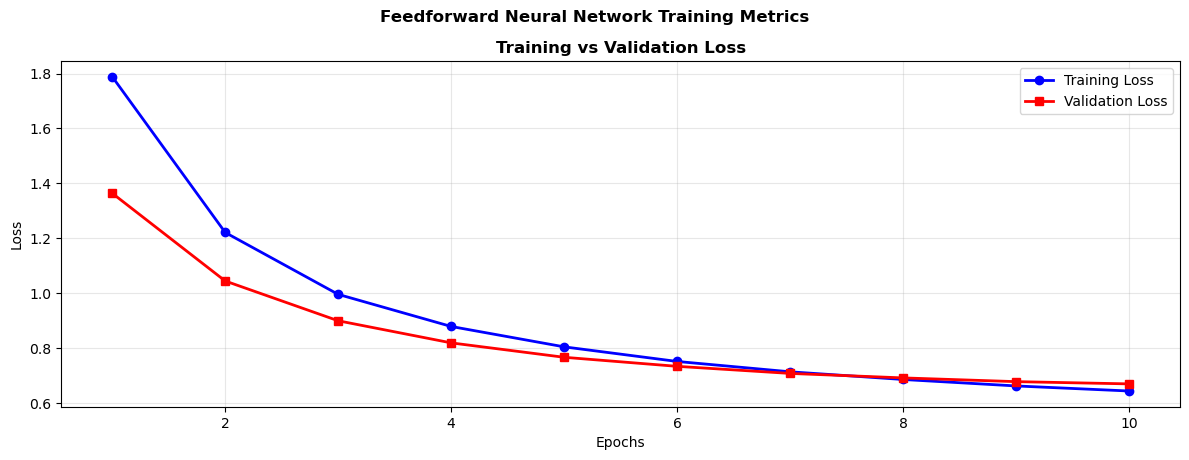

In [ ]:
# plotted training vs validation loss of my feed forward network
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
epochs = range(1, len(train_losses) + 1)
plt.plot(epochs, train_losses, 'b-o', label='Training Loss', linewidth=2, markersize=6)
plt.plot(epochs, val_losses, 'r-s', label='Validation Loss', linewidth=2, markersize=6)
plt.title('Training vs Validation Loss', fontweight='bold')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Feedforward Neural Network Training Metrics', fontweight='bold', y=1.02)
plt.show()


#### Long-Short term memory

In [ ]:
# Reused the same padded Word2Vec embeddings as the LSTM input tensor
x_lstm = get_embedding_matrix(sentences, w2v_model, max_len)
print(x_lstm.shape)

torch.Size([3500, 20, 100])


In [ ]:
# used the same label encoded y
y_lstm = torch.tensor(y, dtype=torch.long)

In [ ]:
# splitted the data
x_lstm_train, x_lstm_val, y_lstm_train, y_lstm_val = train_test_split(
    x_lstm, y_lstm, test_size=0.2, random_state=42
)

In [ ]:
# Defined a custom PyTorch Dataset and DataLoader for LSTM input
class ComplaintDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds_lstm = ComplaintDataset(x_lstm_train, y_lstm_train)
val_ds_lstm = ComplaintDataset(x_lstm_val, y_lstm_val)

train_loader_lstm = DataLoader(train_ds_lstm, batch_size=32, shuffle=True)
val_loader_lstm = DataLoader(val_ds_lstm, batch_size=32)


In [ ]:
# Used Bidirectional LSTM classifier with dropout and two fully-connected layers
class EnhancedLSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.5, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim, 
            hidden_size=hidden_dim,
            num_layers=num_layers, 
            dropout=dropout, 
            batch_first=True, 
            bidirectional=True
        )
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        _, (hidden, _) = self.lstm(x)
        hidden_cat = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        out = self.dropout(hidden_cat)
        out = self.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [ ]:
# Initialize enhanced LSTM model
model_lstm = EnhancedLSTMClassifier(
    input_dim=x_lstm.shape[2],
    hidden_dim=128,
    output_dim=len(torch.unique(y_lstm))
).to(device)

In [ ]:
# I initialized these custom weights so that the lower biased classes get considered
manual_weights = torch.ones(len(encoder.classes_))
manual_weights = torch.ones(len(encoder.classes_))
manual_weights[encoder.transform(['Failed Delivery'])[0]] = 2.0
manual_weights[encoder.transform(['Delivery Delay'])[0]] = 1.5
manual_weights[encoder.transform(['Tracking Issue'])[0]] = 1.5

In [ ]:
# Defined weighted loss to handle class imbalance, Adam optimizer with L2 regularization. 
loss_fn_lstm = nn.CrossEntropyLoss(weight=manual_weights.to(device))
optimizer_lstm = torch.optim.Adam(model_lstm.parameters(), lr=1e-3, weight_decay=1e-4)

tensor(0.)

In [ ]:
# trained and valuated the model here 
num_epochs_lstm = 10
lstm_train_loss_list = []
lstm_val_loss_list = []
lowest_val_loss = float('inf')

for ep in range(num_epochs_lstm):
    model_lstm.train()
    total_train_loss = 0.0
    all_train_preds = []
    all_train_labels = []

    for xb, yb in train_loader_lstm:
        xb, yb = xb.to(device).float(), yb.to(device)

        optimizer_lstm.zero_grad()
        logits = model_lstm(xb)
        loss = loss_fn_lstm(logits, yb)
        loss.backward()
        optimizer_lstm.step()

        total_train_loss += loss.item()
        all_train_preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
        all_train_labels.extend(yb.cpu().numpy())

    avg_lstm_train_loss = total_train_loss / len(train_loader_lstm)
    lstm_train_loss_list.append(avg_lstm_train_loss)

    model_lstm.eval()
    total_val_loss = 0.0
    all_val_preds = []
    all_val_labels = []

    with torch.no_grad():
        for xb, yb in val_loader_lstm:
            xb, yb = xb.to(device).float(), yb.to(device)
            logits = model_lstm(xb)
            loss = loss_fn_lstm(logits, yb)
            total_val_loss += loss.item()

            all_val_preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
            all_val_labels.extend(yb.cpu().numpy())

    avg_lstm_val_loss = total_val_loss / len(val_loader_lstm)
    lstm_val_loss_list.append(avg_lstm_val_loss)

    print(f"Epoch {ep+1} | Train Loss: {avg_lstm_train_loss:.4f} | Val Loss: {avg_lstm_val_loss:.4f}")

    # Here I Saved the model if the validation loss is improved. 
    if avg_lstm_val_loss < lowest_val_loss:
        lowest_val_loss = avg_lstm_val_loss
        torch.save(model_lstm.state_dict(), "best_lstm_model.pth")

Epoch 1 | Train Loss: 1.9113 | Val Loss: 1.2325
Epoch 2 | Train Loss: 1.1894 | Val Loss: 0.9197
Epoch 3 | Train Loss: 0.9072 | Val Loss: 0.7382
Epoch 4 | Train Loss: 0.7612 | Val Loss: 0.6533
Epoch 5 | Train Loss: 0.6833 | Val Loss: 0.6018
Epoch 6 | Train Loss: 0.6370 | Val Loss: 0.5635
Epoch 7 | Train Loss: 0.6095 | Val Loss: 0.5823
Epoch 8 | Train Loss: 0.5898 | Val Loss: 0.5709
Epoch 9 | Train Loss: 0.5637 | Val Loss: 0.5725
Epoch 10 | Train Loss: 0.5613 | Val Loss: 0.5551


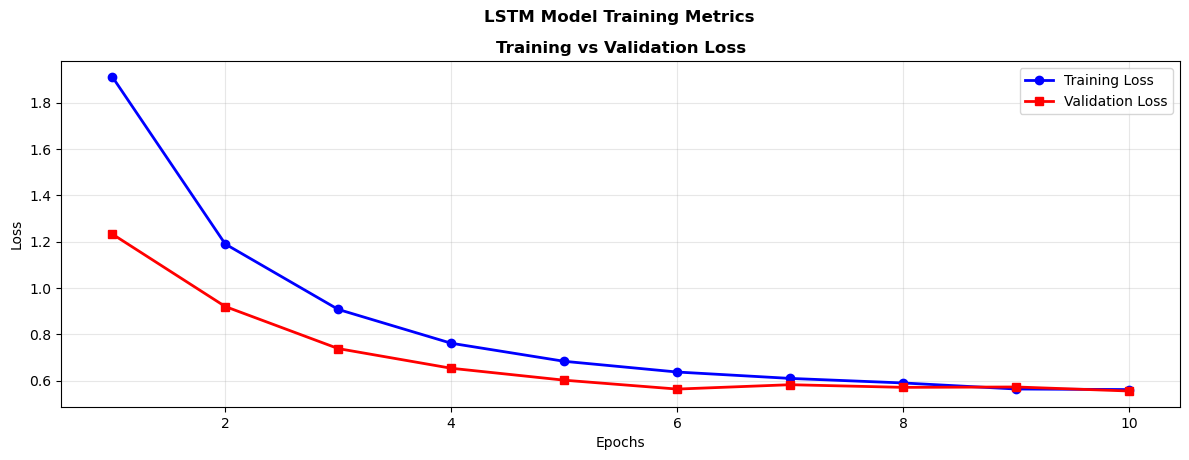

In [ ]:
# visualized the trends of losses
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)

epochs_range = range(1, len(lstm_train_loss_list) + 1)
plt.plot(epochs_range, lstm_train_loss_list, 'b-o', label='Training Loss', linewidth=2, markersize=6)
plt.plot(epochs_range, lstm_val_loss_list, 'r-s', label='Validation Loss', linewidth=2, markersize=6)

plt.title('Training vs Validation Loss', fontweight='bold', x=0.5)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('LSTM Model Training Metrics', fontweight='bold', x=0.52, y=1.02)
plt.show()

#### Evaluation

In [ ]:
# took the best model which is saved in .pth file 
# and got the predictions by validation
model_lstm.load_state_dict(torch.load("best_lstm_model.pth"))
model_lstm.eval()

preds, labels = [], []
with torch.no_grad():
    for X, y in val_loader_lstm:
        X, y = X.to(device).float(), y.to(device)
        out = model_lstm(X)
        preds += torch.argmax(out, 1).cpu().tolist()
        labels += y.cpu().tolist()


In [164]:
print("Accuracy:", round(accuracy_score(labels, preds), 2))

Accuracy: 0.9


In [165]:
print(classification_report(labels, preds, target_names=encoder.classes_))
print('-'*110)
print("Confusion Matrix")
print(confusion_matrix(labels, preds))

                       precision    recall  f1-score   support

        Booking Issue       0.91      0.94      0.93        67
     Customer Service       0.94      0.86      0.90        71
       Damaged Parcel       0.84      0.87      0.86        62
       Delivery Delay       0.96      0.94      0.95        69
      Failed Delivery       0.89      0.94      0.91        67
     Misplaced Parcel       0.87      0.92      0.89        73
         Overcharging       0.87      0.92      0.89        84
Service Quality Issue       0.90      0.90      0.90        67
       Tracking Issue       0.92      0.89      0.90        73
       Wrong Delivery       0.95      0.84      0.89        67

             accuracy                           0.90       700
            macro avg       0.90      0.90      0.90       700
         weighted avg       0.90      0.90      0.90       700

--------------------------------------------------------------------------------------------------------------
Conf

In [ ]:
# Saved the model in models directory
torch.save(model_lstm.state_dict(), 'models/model_lstm.pkl')

#### Custom Complaints

In [176]:
# Converted complaint text into a list of clean tokens
def preprocess(text):
    text = text.lower()
    text = re.sub(r"[^\w\s]", "", text)
    tokens = word_tokenize(text)
    return tokens

# here I embedded words and computed the engineered features and added 
# embeddings to the scaled features 
def sentence_to_ffnn_tensor(sentence, model,scaler, max_len=20, embed_dim=100):
    tokens = word_tokenize(re.sub(r"[^\w\s]", "", sentence.lower()))
    vecs = [torch.tensor(model.wv[w]) for w in tokens if w in model.wv][:max_len]
    vecs += [torch.zeros(embed_dim)] * (max_len - len(vecs))
    embed_part = torch.cat(vecs).unsqueeze(0)
    text_len = len(sentence)
    punct_pct = len(re.findall(r"[^\w\s]", sentence)) / text_len * 100
    feat_df   = pd.DataFrame([[text_len, punct_pct]],
                             columns=['text_len', 'punctuation_percent'])
    scalar_part = torch.tensor(scaler.transform(feat_df),
                               dtype=torch.float32)    
    return torch.cat([embed_part, scalar_part], dim=1)
# Checked with these examples
test_complaints = [
    "My package was left in the rain and all contents were damaged.",
    "DTDC delivered my package to the wrong address and now it's lost.",
    "I've been on hold with DTDC customer service for over 45 minutes without any response.",
    "No one responds to emails or calls regarding my missing parcel.",
    "Unable to track my package as the website keeps showing error code 404.",
    "Tracking information hasn't been updated in 7 days.",
    "DTDC representative at the collection center was very rude to me.",
    "DTDC missed their guaranteed 48-hour delivery window by 5 days.",
    "Website doesn't work properly.",
    "The packaging was damaged and items were missing when I received my delivery.",
    "I paid extra for insurance but DTDC refuses to compensate for the damaged goods.",
]

model_ffnn.eval()
print("FFNN Model Predictions:")
print("="*50)

for complaint in test_complaints:
    x_test = sentence_to_ffnn_tensor(complaint, w2v_model, scaler)  # ← pass scaler
    with torch.no_grad():
        pred_logits = model_ffnn(x_test)
        pred_idx    = torch.argmax(pred_logits, dim=1).item()
        label       = encoder.inverse_transform([pred_idx])[0]
    print(f"Complaint: {complaint}")
    print(f"Predicted Category: {label}")
    print("-"*120)


FFNN Model Predictions:
Complaint: My package was left in the rain and all contents were damaged.
Predicted Category: Damaged Parcel
------------------------------------------------------------------------------------------------------------------------
Complaint: DTDC delivered my package to the wrong address and now it's lost.
Predicted Category: Wrong Delivery
------------------------------------------------------------------------------------------------------------------------
Complaint: I've been on hold with DTDC customer service for over 45 minutes without any response.
Predicted Category: Customer Service
------------------------------------------------------------------------------------------------------------------------
Complaint: No one responds to emails or calls regarding my missing parcel.
Predicted Category: Misplaced Parcel
------------------------------------------------------------------------------------------------------------------------
Complaint: Unable to tra

In [ ]:
# here I converted raw complaints to fixed‐length embedding tensors and 
# predicted categories with the trained model.
def sentence_to_lstm_tensor(sentence, model, max_len=20, embed_dim=100):
    tokens = word_tokenize(re.sub(r"[^\w\s]", "", sentence.lower()))
    vecs = []
    for word in tokens:
        if word in model.wv:
            vecs.append(torch.tensor(model.wv[word]))
    if len(vecs) > max_len:
        vecs = vecs[:max_len]
    elif len(vecs) < max_len:
        pad_len = max_len - len(vecs)
        vecs.extend([torch.zeros(embed_dim)] * pad_len)
    stacked_vecs = torch.stack(vecs)
    return stacked_vecs.unsqueeze(0)

# Loaded the best LSTM model which is in .pth file
model_lstm.load_state_dict(torch.load("best_lstm_model.pth"))
model_lstm.eval()

# predictions are made here
print("LSTM Model Predictions:")
print("="*50)

for complaint in test_complaints:
    x_test = sentence_to_lstm_tensor(complaint, w2v_model)
    with torch.no_grad():
        pred_logits = model_lstm(x_test)
        pred_idx = torch.argmax(pred_logits, dim=1).item()
        label = encoder.inverse_transform([pred_idx])[0]
    
    print(f"Complaint: {complaint}")
    print(f"Predicted Category: {label}")
    print("-"*120)

LSTM Model Predictions:
Complaint: My package was left in the rain and all contents were damaged.
Predicted Category: Damaged Parcel
------------------------------------------------------------------------------------------------------------------------
Complaint: DTDC delivered my package to the wrong address and now it's lost.
Predicted Category: Wrong Delivery
------------------------------------------------------------------------------------------------------------------------
Complaint: I've been on hold with DTDC customer service for over 45 minutes without any response.
Predicted Category: Customer Service
------------------------------------------------------------------------------------------------------------------------
Complaint: No one responds to emails or calls regarding my missing parcel.
Predicted Category: Misplaced Parcel
------------------------------------------------------------------------------------------------------------------------
Complaint: Unable to tra

## MODEL PERFORMANCE REPORT

### 1. FEED-FORWARD NEURAL NETWORK (FFNN)
- **Architecture**: Single linear layer (2002 → 10)
- **Input Features**: Word2Vec embeddings + engineered features
- **Training Epochs**: 10  
- **Optimizer**: Adam (lr=1e-3, weight_decay=1e-4)

**Validation Accuracy**: 0.9000  
**Final Training Loss**: 0.6427  
**Final Validation Loss**: 0.6686


### 2. LSTM CLASSIFIER
- **Architecture**: Bidirectional LSTM + 2 Fully Connected layers  
- **Hidden Dimensions**: 128  
- **Dropout Rate**: 0.5  
- **Class Weights**: Applied to handle class imbalance  
- **Training Epochs**: 10  

**Validation Accuracy**: 0.9014  
**Final Training Loss**: 0.5613  
**Final Validation Loss**: 0.5551


### 3. COMPARISON SUMMARY
- **FFNN Accuracy**: 0.9000  
- **LSTM Accuracy**: 0.9014  
- **Performance Difference**: +0.0014

**Conclusion**: *LSTM outperforms FFNN in validation accuracy.*


### Final Notes:
- Both models effectively classify DTDC customer complaints into **10 categories**.
- Trained models are stored in the models/ directory.
